<a href="https://colab.research.google.com/github/nilakanta123/Short-Term-Load-Forecasting/blob/main/ANN-Tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from numpy import array

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df


# scale train and test data to [-1, 1]
from sklearn.preprocessing import MinMaxScaler
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
import numpy as np
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def train_test_split(dframe,n_steps,time_lag,diff):
  if time_lag:
    raw_values = dframe.load.values
  else:
    day_df = dframe.resample('D').sum()
    raw_values = day_df.load.values
  if diff:
    diff_values = difference(raw_values,1)
  else:
    diff_values = raw_values
  supervised_data = timeseries_to_supervised(diff_values, n_steps)
  n = int(len(supervised_data)/5)
  return supervised_data[0:-n], supervised_data[-n:], raw_values

# define input sequence
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['malaysia_all_data_for_paper.csv']), header=0, parse_dates=[0], index_col=0, squeeze=True)

Saving malaysia_all_data_for_paper.csv to malaysia_all_data_for_paper (1).csv


In [ ]:
df = df[:2000]

In [ ]:
# define model
from keras.models import Sequential
from keras.layers import Dense

def fit_mlp(train,steps,nb_epoch,batch_size, n_neurons):
    X, y = train[:,:-1], train[:,-1]
    model = Sequential()
    model.add(Dense(n_neurons, activation='relu', input_dim=steps))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    for i in range(nb_epoch):
      model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0)
    return model

def forecast_mlp(model, X, steps, batch_size):
    X = X.reshape((1, steps))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


In [ ]:
# PARAMETERS
import math
n_steps = 15
#daily-0 : hourly-1
time_lag = 0
#No-0 : Yes-1
diff = 1
n_features = 1
nb_epoch = 50


neurons = [i for i in range(2,2*n_steps)]

train, test, raw_values = train_test_split(df,n_steps,time_lag,diff)
scaler, train_scaled, test_scaled = scale(train.values, test.values)
print("train : ",len(train))
print("test : ",len(test))
print(train.shape)

print(math.ceil(len(train)/(2*(n_steps+1))))

train :  67
test :  16
(67, 16)
3


RMSE for 2 is 241394.519
RMSE for 3 is 243160.247
RMSE for 4 is 235950.579
RMSE for 5 is 231516.930
RMSE for 6 is 227223.415
RMSE for 7 is 231370.315
RMSE for 8 is 237410.822
RMSE for 9 is 232728.171
RMSE for 10 is 231078.379
RMSE for 11 is 227915.130
RMSE for 12 is 230207.374
RMSE for 13 is 227339.001
RMSE for 14 is 226159.763
RMSE for 15 is 225642.666
RMSE for 16 is 227824.537
RMSE for 17 is 229268.519
RMSE for 18 is 226738.364
RMSE for 19 is 225124.514


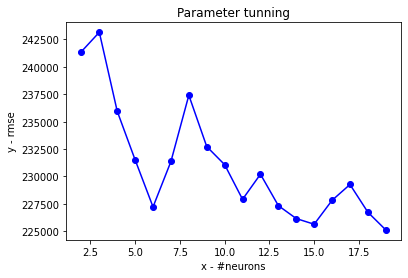

In [ ]:
# demonstrate prediction
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

raw_test = []
if diff:
  for i in range(len(test.values[:,-1])):
    y = inverse_difference(raw_values,test.values[:,-1][i],len(test_scaled)+1-i)
    raw_test.append(y)
else:
  raw_test = test.values[:,-1]

rmse_results = []

for n in neurons:

  repeats = 5
  error_scores = []
  predictions = []

  for r in range(repeats):
      cnn_model = fit_mlp(train_scaled, n_steps, nb_epoch,1, n)
      prediction = []
      for i in range(len(test_scaled)):
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_mlp(cnn_model, X, n_steps,1)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        if diff:
          yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        prediction.append(yhat)
      rmse = sqrt(mean_squared_error(raw_test, prediction))
      error_scores.append(rmse)
      predictions.append(prediction)
  sum=0
  for i in range(repeats):
    sum+=error_scores[i]
  print('RMSE for %d is %.3f' % (n, sum/repeats))
  rmse_results.append(sum/repeats)

from matplotlib import pyplot
plt.plot(neurons, rmse_results, 'o-', color='blue')
#pyplot.plot(predictions[repeats-1], color='red')
plt.xlabel("x - #neurons")
plt.ylabel("y - rmse")
plt.title("Parameter tunning")
plt.show()